### Inspect Dataset

In [1]:
import os

base_input_folder = "/kaggle/input/brain-tumor-mri"

classes = sorted(os.listdir(base_input_folder))
print("Classes found:", classes)

for c in classes:
    class_path = os.path.join(base_input_folder, c)
    num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg','.png','.jpeg'))])
    print(f"{c}: {num_images} slices")


Classes found: ['Astrocitoma T1', 'Astrocitoma T1C+', 'Astrocitoma T2', 'Carcinoma T1', 'Carcinoma T1C+', 'Carcinoma T2', 'Ependimoma T1', 'Ependimoma T1C+', 'Ependimoma T2', 'Ganglioglioma T1', 'Ganglioglioma T1C+', 'Ganglioglioma T2', 'Germinoma T1', 'Germinoma T1C+', 'Germinoma T2', 'Glioblastoma T1', 'Glioblastoma T1C+', 'Glioblastoma T2', 'Granuloma T1', 'Granuloma T1C+', 'Granuloma T2', 'Meduloblastoma T1', 'Meduloblastoma T1C+', 'Meduloblastoma T2', 'Meningioma T1', 'Meningioma T1C+', 'Meningioma T2', 'Neurocitoma T1', 'Neurocitoma T1C+', 'Neurocitoma T2', 'Oligodendroglioma T1', 'Oligodendroglioma T1C+', 'Oligodendroglioma T2', 'Papiloma T1', 'Papiloma T1C+', 'Papiloma T2', 'Schwannoma T1', 'Schwannoma T1C+', 'Schwannoma T2', 'Tuberculoma T1', 'Tuberculoma T1C+', 'Tuberculoma T2', '_NORMAL T1', '_NORMAL T2']
Astrocitoma T1: 176 slices
Astrocitoma T1C+: 232 slices
Astrocitoma T2: 171 slices
Carcinoma T1: 66 slices
Carcinoma T1C+: 112 slices
Carcinoma T2: 73 slices
Ependimoma T1:

### Threshold + Mask

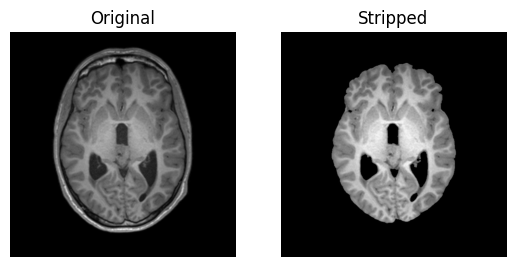

In [2]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt

input_dir = "/kaggle/input/brain-tumor-mri"
output_dir = "/kaggle/working/Threshold+Mask"
os.makedirs(output_dir, exist_ok=True)

for cls in os.listdir(input_dir):
    cls_path = os.path.join(input_dir, cls)
    if not os.path.isdir(cls_path): continue
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)
    for f in os.listdir(cls_path):
        if not f.lower().endswith(('.jpg','.jpeg','.png')): continue
        img_path = os.path.join(cls_path, f)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        _, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
        largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        brain_mask = np.uint8(labels == largest) * 255
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        brain_mask = cv2.morphologyEx(brain_mask, cv2.MORPH_CLOSE, kernel)
        brain_mask = cv2.morphologyEx(brain_mask, cv2.MORPH_OPEN, kernel)
        stripped = cv2.bitwise_and(img, img, mask=brain_mask)
        cv2.imwrite(os.path.join(output_dir, cls, f), stripped)

# preview one result
sample_cls = os.listdir(output_dir)[0]
sample_img = os.listdir(os.path.join(output_dir, sample_cls))[0]
orig = cv2.imread(os.path.join(input_dir, sample_cls, sample_img), cv2.IMREAD_GRAYSCALE)
proc = cv2.imread(os.path.join(output_dir, sample_cls, sample_img), cv2.IMREAD_GRAYSCALE)
plt.subplot(1,2,1); plt.imshow(orig, cmap='gray'); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(proc, cmap='gray'); plt.title("Stripped"); plt.axis('off')
plt.show()


### Crop to Brain

✅ Cropping complete. 4478 images processed and saved to /kaggle/working/brain-tumor-mri-cropped


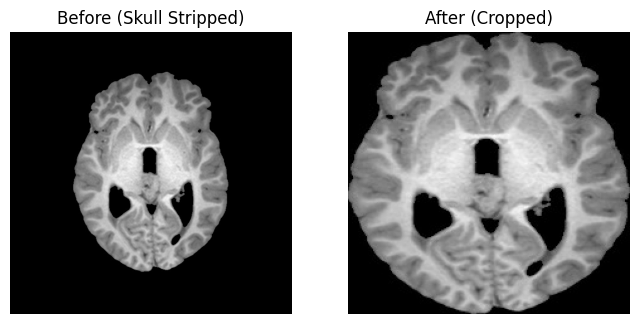

In [3]:
import cv2, os, numpy as np
import matplotlib.pyplot as plt

input_dir = "/kaggle/working/Threshold+Mask"
output_dir = "/kaggle/working/brain-tumor-mri-cropped"
os.makedirs(output_dir, exist_ok=True)

processed_count = 0

for cls in os.listdir(input_dir):
    cls_path = os.path.join(input_dir, cls)
    if not os.path.isdir(cls_path): continue
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)
    for f in os.listdir(cls_path):
        if not f.lower().endswith(('.jpg','.jpeg','.png')): continue
        img_path = os.path.join(cls_path, f)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # mask + bounding box
        _, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
        if num_labels <= 1: continue
        largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        brain_mask = np.uint8(labels == largest) * 255
        coords = cv2.findNonZero(brain_mask)
        x, y, w, h = cv2.boundingRect(coords)

        cropped = img[y:y+h, x:x+w]
        cropped_resized = cv2.resize(cropped, (224,224))
        cv2.imwrite(os.path.join(output_dir, cls, f), cropped_resized)
        processed_count += 1

print(f"✅ Cropping complete. {processed_count} images processed and saved to {output_dir}")

# Preview 
sample_cls = os.listdir(input_dir)[0]
sample_img = os.listdir(os.path.join(input_dir, sample_cls))[0]

orig = cv2.imread(os.path.join(input_dir, sample_cls, sample_img), cv2.IMREAD_GRAYSCALE)
proc = cv2.imread(os.path.join(output_dir, sample_cls, sample_img), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(orig, cmap='gray'); plt.title("Before (Skull Stripped)"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(proc, cmap='gray'); plt.title("After (Cropped)"); plt.axis('off')
plt.show()


### Denoising

✅ Denoising complete. 4478 images saved to /kaggle/working/brain-tumor-mri-denoised


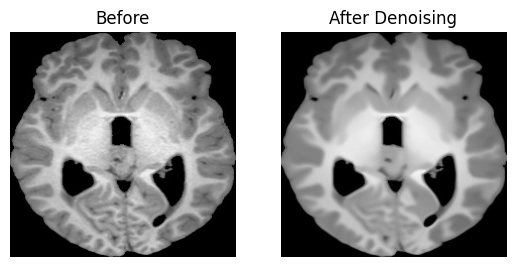

In [4]:
import cv2, os
import matplotlib.pyplot as plt

input_dir = "/kaggle/working/brain-tumor-mri-cropped"
output_dir = "/kaggle/working/brain-tumor-mri-denoised"
os.makedirs(output_dir, exist_ok=True)

count = 0
for cls in os.listdir(input_dir):
    cls_path = os.path.join(input_dir, cls)
    if not os.path.isdir(cls_path): continue
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)
    for f in os.listdir(cls_path):
        if not f.lower().endswith(('.jpg','.jpeg','.png')): continue
        img = cv2.imread(os.path.join(cls_path, f), cv2.IMREAD_GRAYSCALE)
        denoised = cv2.fastNlMeansDenoising(img, None, h=10, templateWindowSize=7, searchWindowSize=21)
        cv2.imwrite(os.path.join(output_dir, cls, f), denoised)
        count += 1

print(f"✅ Denoising complete. {count} images saved to {output_dir}")

# preview
sample_cls = os.listdir(input_dir)[0]
sample_img = os.listdir(os.path.join(input_dir, sample_cls))[0]
orig = cv2.imread(os.path.join(input_dir, sample_cls, sample_img), cv2.IMREAD_GRAYSCALE)
proc = cv2.imread(os.path.join(output_dir, sample_cls, sample_img), cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1); plt.imshow(orig, cmap='gray'); plt.title("Before"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(proc, cmap='gray'); plt.title("After Denoising"); plt.axis('off')
plt.show()


### Inspection of image types 

In [5]:
import os
from collections import defaultdict

input_dir = "/kaggle/working/brain-tumor-mri-denoised"

class_format_counts = {}
total_counts = defaultdict(int)

for cls in sorted(os.listdir(input_dir)):
    cls_path = os.path.join(input_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    format_counter = defaultdict(int)
    for f in os.listdir(cls_path):
        ext = os.path.splitext(f)[1].lower()  # get extension including dot
        format_counter[ext] += 1
        total_counts[ext] += 1

    class_format_counts[cls] = dict(format_counter)

# Print per-class format counts
for cls, counts in class_format_counts.items():
    counts_str = ", ".join([f"{ext[1:]}: {cnt}" for ext, cnt in counts.items()])
    print(f"{cls}: {counts_str}")

# Print overall totals
print("\nOverall format counts across all classes:")
for ext, cnt in total_counts.items():
    print(f"{ext[1:]}: {cnt}")


Astrocitoma T1: jpg: 48, jpeg: 128
Astrocitoma T1C+: jpeg: 185, jpg: 47
Astrocitoma T2: jpeg: 131, jpg: 40
Carcinoma T1: jpeg: 60, jpg: 6
Carcinoma T1C+: jpeg: 102, jpg: 10
Carcinoma T2: jpeg: 63, jpg: 10
Ependimoma T1: jpeg: 41, jpg: 4
Ependimoma T1C+: jpg: 14, jpeg: 34
Ependimoma T2: jpeg: 37, jpg: 20
Ganglioglioma T1: jpg: 13, jpeg: 7
Ganglioglioma T1C+: jpg: 12, jpeg: 6
Ganglioglioma T2: jpg: 13, jpeg: 10
Germinoma T1: jpeg: 18, jpg: 9
Germinoma T1C+: jpeg: 26, jpg: 14
Germinoma T2: jpg: 20, jpeg: 13
Glioblastoma T1: jpeg: 51, jpg: 4
Glioblastoma T1C+: jpeg: 88, jpg: 6
Glioblastoma T2: jpg: 5, jpeg: 50
Granuloma T1: jpeg: 27, jpg: 3
Granuloma T1C+: jpeg: 26, jpg: 5
Granuloma T2: jpeg: 14, jpg: 3
Meduloblastoma T1: jpeg: 23
Meduloblastoma T1C+: jpeg: 59, jpg: 8
Meduloblastoma T2: jpg: 12, jpeg: 29
Meningioma T1: jpeg: 141, jpg: 131
Meningioma T1C+: jpeg: 151, jpg: 218
Meningioma T2: jpg: 134, jpeg: 99
Neurocitoma T1: jpeg: 91, jpg: 39
Neurocitoma T1C+: jpeg: 147, jpg: 76
Neurocitoma

### Intensity Normalization + Resizing

In [6]:
import cv2, os, numpy as np

input_dir = "/kaggle/working/brain-tumor-mri-denoised"
output_dir = "/kaggle/working/brain-tumor-mri-normalized"
os.makedirs(output_dir, exist_ok=True)

total_count = 0
created_dirs = 0
per_class_counts = {}

for cls in sorted(os.listdir(input_dir)):
    cls_path = os.path.join(input_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    out_cls_dir = os.path.join(output_dir, cls)
    os.makedirs(out_cls_dir, exist_ok=True)
    created_dirs += 1
    cls_count = 0

    for f in os.listdir(cls_path):
        if not f.lower().endswith(('.jpg', '.jpeg')):
            continue
        in_path = os.path.join(cls_path, f)
        img = cv2.imread(in_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f" Skipped unreadable file: {in_path}")
            continue
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
        norm = cv2.normalize(img.astype(np.float32), None, 0.0, 1.0, cv2.NORM_MINMAX)
        base = os.path.splitext(f)[0]
        out_path = os.path.join(out_cls_dir, base + ".npy")
        np.save(out_path, norm)
        cls_count += 1
        total_count += 1

    per_class_counts[cls] = cls_count

# Summary
print(f"✅ Normalization + resizing complete. {total_count} images saved into {created_dirs} class folders at: {output_dir}")


✅ Normalization + resizing complete. 4478 images saved into 44 class folders at: /kaggle/working/brain-tumor-mri-normalized


### Contrast Enhancement (CLAHE)

✅ CLAHE complete. 4478 images saved to /kaggle/working/brain-tumor-mri-clahe


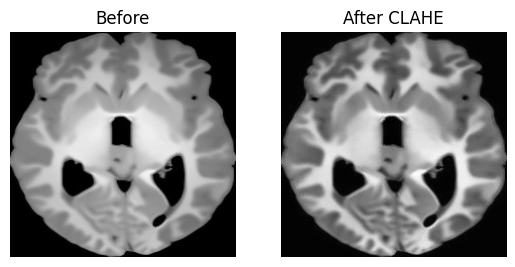

In [7]:
import cv2, os, matplotlib.pyplot as plt

input_dir = "/kaggle/working/brain-tumor-mri-denoised"
output_dir = "/kaggle/working/brain-tumor-mri-clahe"
os.makedirs(output_dir, exist_ok=True)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
count = 0

for cls in os.listdir(input_dir):
    cls_path = os.path.join(input_dir, cls)
    if not os.path.isdir(cls_path): continue
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)
    for f in os.listdir(cls_path):
        if not f.lower().endswith(('.jpg','.jpeg','.png')): continue
        img = cv2.imread(os.path.join(cls_path, f), cv2.IMREAD_GRAYSCALE)
        enhanced = clahe.apply(img)
        cv2.imwrite(os.path.join(output_dir, cls, f), enhanced)
        count += 1

print(f"✅ CLAHE complete. {count} images saved to {output_dir}")

# preview
sample_cls = os.listdir(input_dir)[0]
sample_img = os.listdir(os.path.join(input_dir, sample_cls))[0]
orig = cv2.imread(os.path.join(input_dir, sample_cls, sample_img), cv2.IMREAD_GRAYSCALE)
proc = cv2.imread(os.path.join(output_dir, sample_cls, sample_img), cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1); plt.imshow(orig, cmap='gray'); plt.title("Before"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(proc, cmap='gray'); plt.title("After CLAHE"); plt.axis('off')
plt.show()

### After Preprocessing

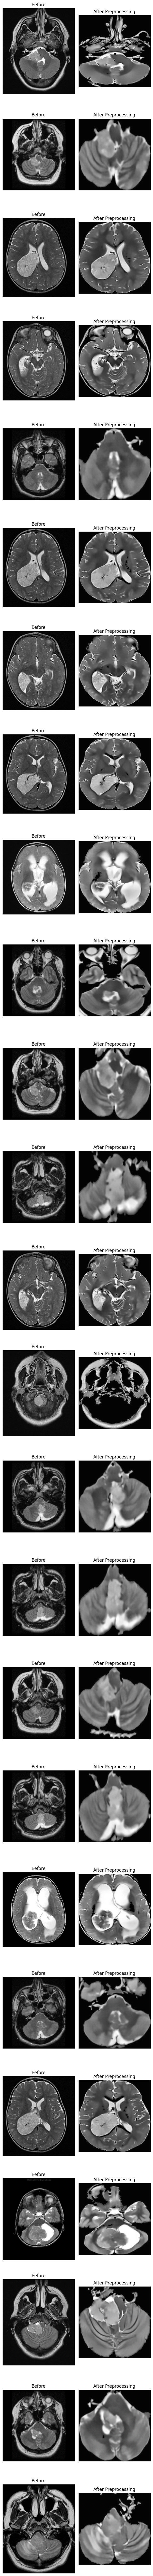

In [8]:
import cv2, os, matplotlib.pyplot as plt

before_dir = "/kaggle/input/brain-tumor-mri"
after_dir  = "/kaggle/working/brain-tumor-mri-clahe"

# Collect 25 image paths (same filenames exist in both dirs)
before_paths, after_paths = [], []
count = 0
for cls in os.listdir(before_dir):
    cls_path = os.path.join(before_dir, cls)
    if not os.path.isdir(cls_path): continue
    for f in os.listdir(cls_path):
        if not f.lower().endswith(('.jpg','.jpeg','.png')): continue
        before_paths.append(os.path.join(before_dir, cls, f))
        after_paths.append(os.path.join(after_dir, cls, f))
        count += 1
        if count >= 25: break
    if count >= 25: break

# Plot vertically: 25 rows, 2 columns (Before | After)
fig, axes = plt.subplots(nrows=25, ncols=2, figsize=(6, 100))  # tall figure
for i, (b_path, a_path) in enumerate(zip(before_paths, after_paths)):
    orig = cv2.imread(b_path, cv2.IMREAD_GRAYSCALE)
    proc = cv2.imread(a_path, cv2.IMREAD_GRAYSCALE)

    axes[i,0].imshow(orig, cmap='gray')
    axes[i,0].set_title("Before")
    axes[i,0].axis('off')

    axes[i,1].imshow(proc, cmap='gray')
    axes[i,1].set_title("After Preprocessing")
    axes[i,1].axis('off')

plt.tight_layout()
plt.show()

### Augmentations

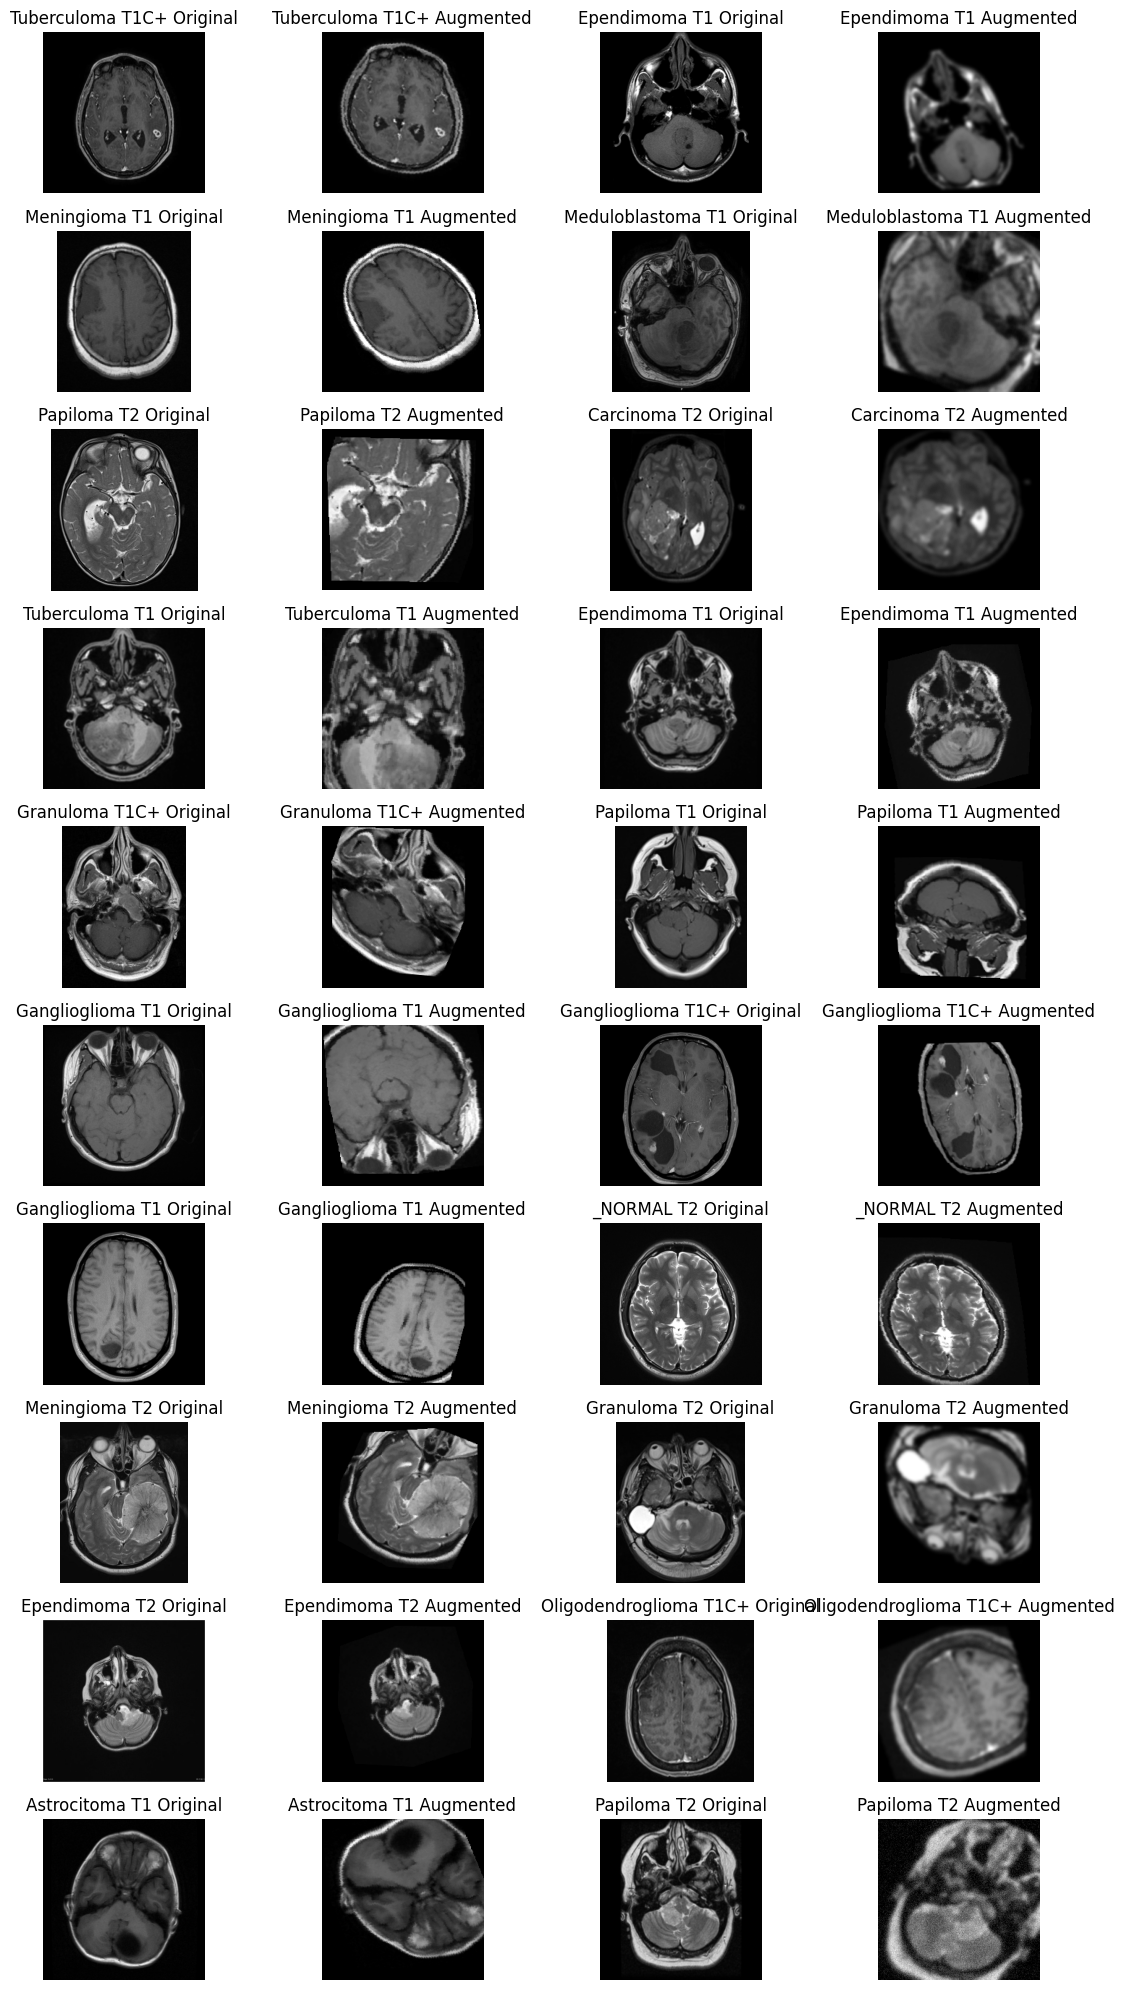

In [17]:
import os, random
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import numpy as np
import torch
from torchvision import transforms

# stronger augmentation
class AddGaussianBlur:
    def __init__(self, radius=2.0, p=0.3): self.radius, self.p = radius, p
    def __call__(self, img):
        return img.filter(ImageFilter.GaussianBlur(self.radius)) if random.random() < self.p else img

class AddRandomNoise:
    def __init__(self, p=0.25, std=0.05): self.p, self.std = p, std
    def __call__(self, img):
        if random.random() < self.p:
            arr = np.array(img).astype(np.float32) / 255.0
            arr = np.clip(arr + np.random.normal(0, self.std, arr.shape), 0, 1)
            return Image.fromarray((arr * 255).astype(np.uint8))
        return img

def build_transform():
    return transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomResizedCrop(224, scale=(0.6,1.0)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.3),
        transforms.RandomRotation(25),
        transforms.RandomAffine(0, translate=(0.1,0.1), scale=(0.8,1.2), shear=10),
        transforms.RandomPerspective(0.2, p=0.4),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        AddGaussianBlur(2.0,0.3),
        AddRandomNoise(0.25,0.05)
    ])

raw_dir = "/kaggle/input/brain-tumor-mri"
tform = build_transform()

all_classes = [d for d in os.listdir(raw_dir) if os.path.isdir(os.path.join(raw_dir, d))]
samples = []
for c in all_classes:
    files = [f for f in os.listdir(os.path.join(raw_dir, c)) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    if files:
        samples.extend([(c, f) for f in random.sample(files, min(5, len(files)))])
samples = random.sample(samples, min(20, len(samples)))

plt.figure(figsize=(12,20))
for i, (cls, fname) in enumerate(samples):
    img_path = os.path.join(raw_dir, cls, fname)
    img = Image.open(img_path).convert("L")
    aug = tform(img)
    plt.subplot(10,4,2*i+1); plt.imshow(img, cmap='gray'); plt.title(f"{cls} Original"); plt.axis('off')
    plt.subplot(10,4,2*i+2); plt.imshow(aug, cmap='gray'); plt.title(f"{cls} Augmented"); plt.axis('off')
plt.tight_layout()
plt.show()


### Train + Val + Test (70+15+15)

In [13]:
import os, shutil, random

input_dir = "/kaggle/working/brain-tumor-mri-clahe"
output_base = "/kaggle/working/brain-tumor-mri-split"
splits = ["train","val","test"]
ratios = [0.7,0.15,0.15]

for s in splits:
    for cls in os.listdir(input_dir):
        os.makedirs(os.path.join(output_base,s,cls), exist_ok=True)

for cls in os.listdir(input_dir):
    cls_path = os.path.join(input_dir, cls)
    if not os.path.isdir(cls_path): continue
    files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    random.shuffle(files)
    n = len(files)
    n_train, n_val = int(n*ratios[0]), int(n*ratios[1])
    train_files = files[:n_train]
    val_files = files[n_train:n_train+n_val]
    test_files = files[n_train+n_val:]
    for f in train_files:
        shutil.copy(os.path.join(cls_path,f), os.path.join(output_base,"train",cls,f))
    for f in val_files:
        shutil.copy(os.path.join(cls_path,f), os.path.join(output_base,"val",cls,f))
    for f in test_files:
        shutil.copy(os.path.join(cls_path,f), os.path.join(output_base,"test",cls,f))

def count_images(path):
    total = 0
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if not os.path.isdir(cls_path): continue
        total += len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    return total

print("✅ Split complete. Data saved to", output_base)
print("Train:", count_images(os.path.join(output_base,"train")))
print("Val:", count_images(os.path.join(output_base,"val")))
print("Test:", count_images(os.path.join(output_base,"test")))

✅ Split complete. Data saved to /kaggle/working/brain-tumor-mri-split
Train: 11214
Val: 3108
Test: 3232


### Train Test Val (70+15+15)

In [18]:
import os, shutil, random

input_dir = "/kaggle/working/brain-tumor-mri-aug2x"
output_base = "/kaggle/working/brain-tumor-mri-split"
splits = ["train","val","test"]
ratios = [0.7,0.15,0.15]

for s in splits:
    for cls in os.listdir(input_dir):
        os.makedirs(os.path.join(output_base, s, cls), exist_ok=True)

for cls in os.listdir(input_dir):
    files = [f for f in os.listdir(os.path.join(input_dir, cls)) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    random.shuffle(files)
    n = len(files)
    n_train, n_val = int(n*ratios[0]), int(n*ratios[1])
    splits_files = {
        "train": files[:n_train],
        "val": files[n_train:n_train+n_val],
        "test": files[n_train+n_val:]
    }
    for s, fs in splits_files.items():
        for f in fs:
            shutil.copy2(os.path.join(input_dir, cls, f), os.path.join(output_base, s, cls, f))

counts = {}
for split in splits:
    total = 0
    for cls in os.listdir(os.path.join(output_base, split)):
        cls_path = os.path.join(output_base, split, cls)
        n = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.jpeg','.png'))])
        total += n
    counts[split] = total

print(f"✅ Split complete. Data saved to {output_base}")
print(f"Train: {counts['train']}")
print(f"Val: {counts['val']}")
print(f"Test: {counts['test']}")


✅ Split complete. Data saved to /kaggle/working/brain-tumor-mri-split
Train: 12025
Val: 5552
Test: 5776
